In [1]:
import GPy
import numpy as np
import math
from matplotlib import pyplot as plt

# Finding the gaussian process gradiants using GPy toolkit.
### true function: $$f(x)=x\sin(x)$$
Add uniform random noise in the range (-0.6,+0.6) and get 20 samples. We will fit a gaussian process to these samples.

In [2]:
def f(x):
    """define the main function here"""
    return x*np.sin(x)
def f_grad(x):
    """define the gradiant of the main function here"""
    return np.sin(x)+x*np.cos(x)

In [3]:
x = np.random.uniform(-3.,3.,(20,1))
y = f(x) + np.random.randn(20,1)*0.2
x_true=np.linspace(-3,3,100)
y_true=f(x_true)

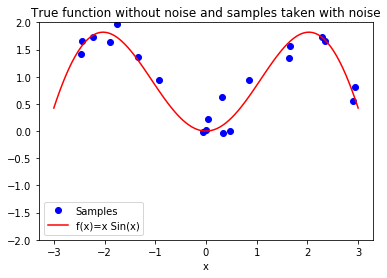

In [4]:
#plt.figure(figsize=(20,5))
plt.plot(x,y,'bo',label='Samples')
plt.plot(x_true,y_true,'r',label=r'f(x)=x Sin(x)')
plt.legend()
plt.ylim(-2,2)
plt.xlabel('x')
plt.title('True function without noise and samples taken with noise')
plt.show()

### Use GPy module to fit a gausian process to these samples

In [5]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(x,y,kernel)
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 9.889118659978767
Optimization restart 2/10, f = 9.889118659913837
Optimization restart 3/10, f = 9.889118659860236
Optimization restart 4/10, f = 9.889118659860832
Optimization restart 5/10, f = 9.88911865985941
Optimization restart 6/10, f = 9.889118659859193
Optimization restart 7/10, f = 9.88911866076461
Optimization restart 8/10, f = 9.88911865985809
Optimization restart 9/10, f = 9.889118659889867
Optimization restart 10/10, f = 9.889118659857484


GP_regression.,value,constraints,priors
rbf.variance,1.5073045484496825,+ve,
rbf.lengthscale,1.2798319510752079,+ve,
Gaussian_noise.variance,0.05072959239173773,+ve,


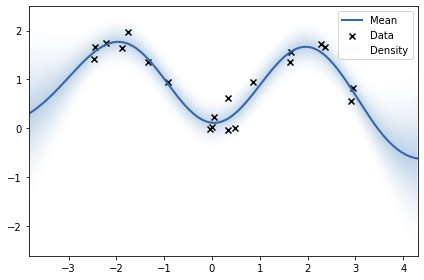

In [6]:
display(m)
fig = m.plot(plot_density=True)
#GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [7]:
x_predict=np.array([[i] for i in np.arange(-3,3,0.01)])#dim=(1*number of prediction points)
y_predict,var_predict=m.predict(Xnew=x_predict)  
sigma_predict=np.sqrt(var_predict)

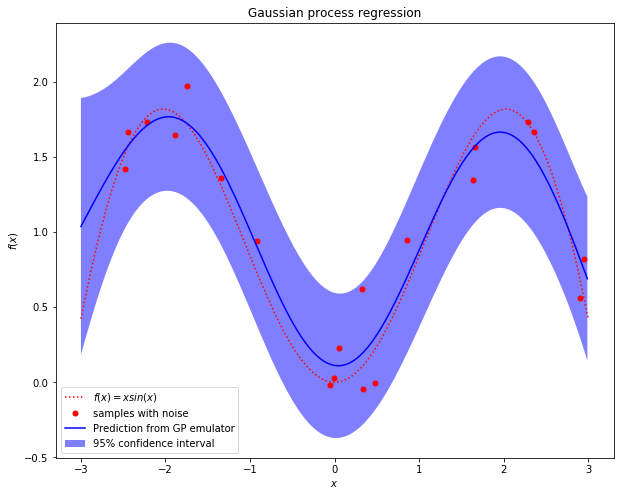

In [8]:
# Plot the function, the prediction and the 95% confidence interval
plt.figure(figsize=(10,8))
plt.plot(x_true,y_true, 'r:', label=r'$f(x) = x sin(x)$')
plt.plot(x,y, 'r.', markersize=10, label='samples with noise')
plt.plot(x_predict, y_predict, 'b-', label='Prediction from GP emulator')
#plt.fill(np.concatenate([x_predict, x_predict[::-1]]),np.concatenate([y_predict - 1.9600 * sigma_predict,(y_predict + 1.9600 * sigma_predict)[::-1]]),
#         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('Gaussian process regression')
#plt.ylim(-0.5, 3)
plt.legend(loc='lower left')

### Find the gradiant of the above Gaussian process and plot it in the same plot. Use inbuilt tool of Gpy library

In [9]:
mean_grad,var_grad=m.predict_jacobian(Xnew=x_predict)
sigma_grad=np.sqrt(np.reshape(var_grad,(600,1)))
mean_grad=np.reshape(mean_grad,(600,1))

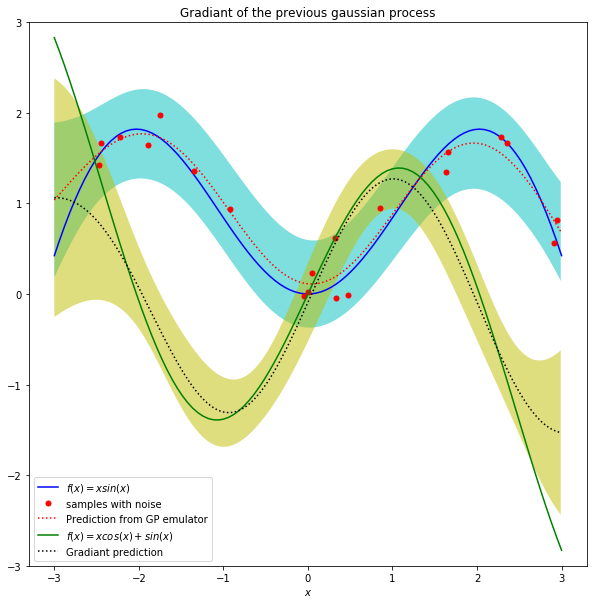

In [10]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(10,10))
plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
plt.plot(x,y, 'r.', markersize=10, label='samples with noise')
plt.plot(x_predict, y_predict, 'r:', label='Prediction from GP emulator')
plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
plt.xlabel('$x$')
plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
plt.plot(x_predict, mean_grad, 'k:', label='Gradiant prediction')
plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='y', ec='None')
plt.title('Gradiant of the gaussian process found by Gpy')
plt.ylim(-3, 3)
plt.legend(loc='lower left')

# Now we will write our own code (instead of using Gpy toolkit) to find the gradiant of the GP with uncertinity. 

#### Get trained GP parameters. We still use Gpy to get this. But this can easily replaced with scikit learn Gaussian process toolkits.

In [11]:
params=m.param_array
print('rbf variance {}, rbf length scale {}, noise variance {}'.format(*params))

rbf variance 1.5073045484496825, rbf length scale 1.2798319510752079, noise variance 0.05072959239173773


#### Define functions that calculates rbf_covariance and it's first and second derivative

In [12]:
def cov_k(x_i,x_j,var_f=params[0],L=params[1]):
    """Takes two x values as inputs and calculate the rbf kernal covariance between the two with the trained 
    rbf lenght value
    k(x_i,x_j)"""
    return (var_f)*np.exp(-1*((x_i-x_j)**2)/(2*(L**2)))

In [13]:
def cov_dK_dx_star(x_star,x,L=params[1]):
    """Calculate the first derivative of rbf kernal wrt the first parameter (x_star)"""
    return -(1/(L**2))*(x_star-x)*cov_k(x_star,x)

In [14]:
def cov_d2k_dXdX(x_star,x,L=params[1]):
    """Calculate the second derivative (only cross terms) of the rbf kernal which is symetric under change of differentiation order
    (x_star or x)"""
    return (1/(L**2))*(1-(((x_star-x)**2)*(1/(L**2))))*cov_k(x_star,x)

#### Functions to define the covariance matrices for many prediction points for the GP

In [15]:
def generate_K(X_i,X_j):
    """Generates the full covariance for the two input arrays X_i and X_j"""
    raws=len(X_i)
    clmns=len(X_j)
    K=np.zeros((raws,clmns))
    for i in range(0,raws):
        for j in range(0,clmns):
            K[i][j]=cov_k(X_i[i][0],X_j[j][0])
    return K

In [16]:
def generate_dK(X_i,X_j):
    """Generate first derivative matrix of the kernal for two input arrays"""
    raws=len(X_i)
    clmns=len(X_j)
    K=np.zeros((raws,clmns))
    for i in range(0,raws):
        for j in range(0,clmns):
            K[i][j]=cov_dK_dx_star(X_i[i][0],X_j[j][0])
    return K

In [17]:
def generate_d2K(X_i,X_j):
    """Second derivative matrix of the kernal. This is complicated and this function is only valid when both
    the input arguments for this function are the same array. List of x values of predictive (star) points"""
    raws=len(X_i)
    clmns=len(X_j)
    K=np.zeros((raws,clmns))
    for i in range(0,raws):
        for j in range(0,clmns):
            if i==j:
                #For diaganal values there is an extra negative sign
                K[i][j]=-1*cov_d2k_dXdX(X_i[i][0],X_j[j][0])
            else:
                K[i][j]=cov_d2k_dXdX(X_i[i][0],X_j[j][0])

    return K

#### Finding the mean of the gradiant using above defined functions

In [18]:
k=generate_K(x,x)
noise_var=np.diag([params[2] for i in range(0,k.shape[0])])
woodbury_matrix=np.linalg.inv(noise_var+k)

In [19]:
dK=generate_dK(x_predict,x)

In [20]:
dK.shape

(600, 20)

In [21]:
mean_grad_my=np.matmul(dK,np.matmul(woodbury_matrix,y))

In [22]:
#mean_grad_my-mean_grad

In [23]:
var_grad_my=generate_d2K(x_predict,x_predict)+np.matmul(np.matmul(dK,woodbury_matrix),dK.T)

In [24]:
#np.matmul(np.matmul(dK,Mel_matrix),dK.T).diagonal()

In [25]:
#generate_d2K(x_predict,x_predict).diagonal()

In [26]:
#var_grad_my.diagonal()

In [27]:
#This step is questionable. Some of the variance values are negative. Have to look into this issue
sigma_grad_my=np.sqrt([abs(i) for i in var_grad_my.diagonal()])

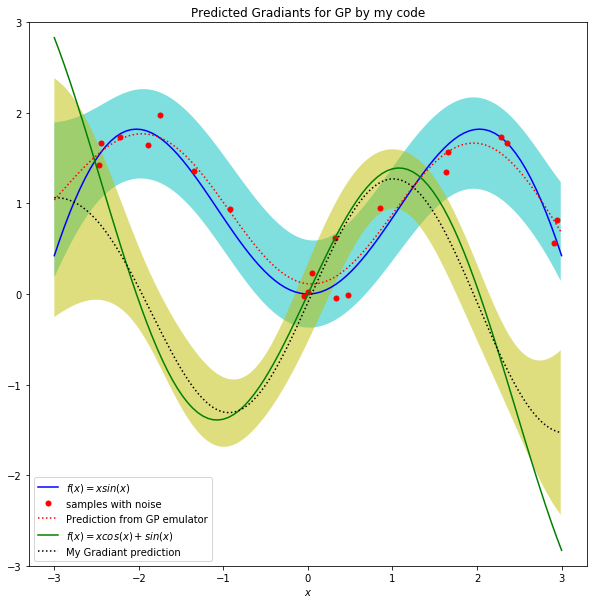

In [28]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(10,10))
plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
plt.plot(x,y, 'r.', markersize=10, label='samples with noise')
plt.plot(x_predict, y_predict, 'r:', label='Prediction from GP emulator')
plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
plt.xlabel('$x$')
plt.plot(x_true,x_true*np.cos(x_true)+np.sin(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
plt.plot(x_predict, mean_grad_my, 'k:', label='My Gradiant prediction')
plt.fill_between(x_predict.flatten(),mean_grad_my.flatten() - 1.9600 * sigma_grad_my.flatten(),mean_grad_my.flatten() + 1.9600 * sigma_grad_my.flatten(), alpha=.5, fc='y', ec='None')
plt.title('Predicted Gradiants for GP by my code')
plt.ylim(-3, 3)
plt.legend(loc='lower left')

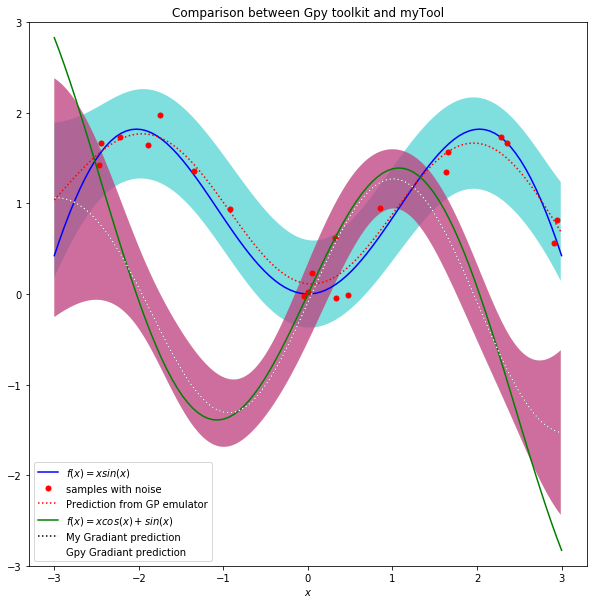

In [29]:

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(10,10))
plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
plt.plot(x,y, 'r.', markersize=10, label='samples with noise')
plt.plot(x_predict, y_predict, 'r:', label='Prediction from GP emulator')
plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
plt.xlabel('$x$')
plt.plot(x_true,x_true*np.cos(x_true)+np.sin(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
plt.plot(x_predict, mean_grad_my, 'k:', label='My Gradiant prediction')
plt.fill_between(x_predict.flatten(),mean_grad_my.flatten() - 1.9600 * sigma_grad_my.flatten(),mean_grad_my.flatten() + 1.9600 * sigma_grad_my.flatten(), alpha=.5, fc='y', ec='None')
plt.title('Comparison between Gpy toolkit and myTool')


plt.plot(x_predict, mean_grad, 'w:', label='Gpy Gradiant prediction')
plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='m', ec='None')


plt.ylim(-3, 3)
plt.legend(loc='lower left')
